In [1]:
# Other imports
import numpy as np
import torch
import sys
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from collections import Counter
import pdb
sys.path.append('..')

# DeepCASE Imports
from deepcase.preprocessing   import Preprocessor
from deepcase.context_builder import ContextBuilder
from deepcase.interpreter     import Interpreter

import matplotlib.pyplot as plt



DEBUG = True
context_length = 50

if DEBUG:
    config = {
    'learning_rates': [0.001],
    'eps':            [0.2],        # Epsilon value to use for DBSCAN clustering, in paper this was 0.1 
    'threshold':      [0.2]
    }
    epochs = 5
else:
    config = {
        'learning_rates': [0.001,0.0001,0.00001],
        'eps':            [0.3,0.2,0.15,0.1],        # Epsilon value to use for DBSCAN clustering, in paper this was 0.1 
        'threshold':      [0.2,0.15,0.1,0.05,0.01]         # Confidence threshold used for determining if attention from the ContextBuilder can be used, in paper this was 0.2
        }


########################################################################
#                             Loading data                             #
########################################################################

# define dictionary of parameters


# Create preprocessor
preprocessor = Preprocessor(
    length  = context_length,    # 10 events in context
    timeout = 86400, # Ignore events older than 1 day (60*60*24 = 86400 seconds)
)

# Load data from file
fox_alerts = '../../../datasets/ait_alerts_csv/alerts_csv/fox_alerts.txt'
harrison_alerts = '../../../datasets/ait_alerts_csv/alerts_csv/harrison_alerts.txt'
russellmitchell_alerts = '../../../datasets/ait_alerts_csv/alerts_csv/russellmitchell_alerts.txt'
santos_alerts = '../../../datasets/ait_alerts_csv/alerts_csv/santos_alerts.txt'
shaw_alerts = '../../../datasets/ait_alerts_csv/alerts_csv/shaw_alerts.txt'
wardbeck_alerts = '../../../datasets/ait_alerts_csv/alerts_csv/wardbeck_alerts.txt'
wheeler_alerts = '../../../datasets/ait_alerts_csv/alerts_csv/wheeler_alerts.txt'
wilson_alerts = '../../../datasets/ait_alerts_csv/alerts_csv/wilson_alerts.txt'

#context, events, mapping, mapping_label, labels  = preprocessor.text(fox_alerts)
context, events,  mapping, mapping_label, labels = preprocessor.text(fox_alerts,harrison_alerts,russellmitchell_alerts,santos_alerts,shaw_alerts,wardbeck_alerts,wheeler_alerts,wilson_alerts)
#context, events,  mapping, mapping_label, labels = preprocessor.text(fox_alerts,harrison_alerts,russellmitchell_alerts,santos_alerts,shaw_alerts,wardbeck_alerts,wheeler_alerts,wilson_alerts)
#pdb.set_trace()
events = torch.tensor(np.array(events))
#labels = torch.tensor(np.array(labels))
labels = torch.tensor(np.array(labels))

# In case no labels are provided, set labels to -1
# IMPORTANT: If no labels are provided, make sure to manually set the labels
# before calling the interpreter.score_clusters method. Otherwise, this will
# raise an exception, because scores == NO_SCORE cannot be computed.
if labels is None:
    labels = np.full(events.shape[0], -1, dtype=int)

# Cast to cuda if available
if torch.cuda.is_available():
    events  = events.to('cuda')
    context = context.to('cuda')


    

In [2]:
print(f'the total number of samples: {len(labels)}')
print(f'the number of false positive: {sum(labels==0)}')
print(f'the number of analomal samples: {sum(labels==1)} ')

the total number of samples: 380588
the number of false positive: 357548
the number of analomal samples: 23040 


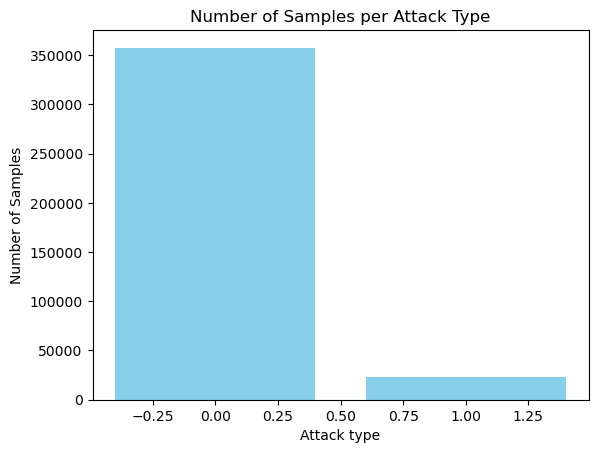

In [3]:
counter_bin = Counter(np.array(labels))
labels_bin = list(counter_bin.keys())
values_bin = list(counter_bin.values())

plt.figure()
plt.bar(labels_bin,values_bin,color='skyblue')
plt.xlabel("Attack type")
plt.ylabel("Number of Samples")
plt.title("Number of Samples per Attack Type")
plt.show()


In [4]:
########################################################################
#                            Splitting data                            #
########################################################################

# # Split into train and test sets (20:80) by time - assuming events are ordered chronologically
# events_test  = events [:events.shape[0]//5 ]
# events_train   = events [ events.shape[0]//5:]

# context_test = context[:events.shape[0]//5 ]
# context_train  = context[ events.shape[0]//5:]

# #labels_train  = labels [:events.shape[0]//5 ]
# #labels_test   = labels [ events.shape[0]//5:]

# labels_test_binary  = labels[:events.shape[0]//5 ]
# labels_train_binary   = labels[ events.shape[0]//5:]

context_train, context_test, labels_train_binary,labels_test_binary = train_test_split(context,labels,test_size=0.4,random_state=35)
events_train , events_test ,                                        = train_test_split(events, test_size=0.4,random_state=35)


In [5]:
########################################################################
#                         Using ContextBuilder                         #
########################################################################

vocab_size = len(np.unique(list(mapping)))
# embed_size = 128
# num_heads = 4
# hidden_size = 256
# num_layers = 4
# num_classes = len(np.unique(labels.to('cpu')))
# max_seq_length = 10
# Create ContextBuilder
context_builder = ContextBuilder(
    input_size    = vocab_size,   # Number of input features to expect
    output_size   = vocab_size,   # Same as input size
    hidden_size   = 128,   # Number of nodes in hidden layer, in paper we set this to 128
    max_length    = context_length,    # Length of the context, should be same as context in Preprocessor
)

# Cast to cuda if available
if torch.cuda.is_available():
    context_builder = context_builder.to('cuda')

# Train the ContextBuilder
context_builder.fit(
    X             = context_train,               # Context to train with
    y             = events_train.reshape(-1, 1), # Events to train with, note that these should be of shape=(n_events, 1)
    labels        = labels_train_binary,
    epochs        = 100,                          # Number of epochs to train with
    batch_size    = 128,                         # Number of samples in each training batch, in paper this was 128
    learning_rate = 0.001,                        # Learning rate to train with, in paper this was 0.01
    verbose       = True,                        # If True, prints progress
)


[Epoch 100/100 loss=0.010138]: 100%|██████████| 1784/1784 [00:30<00:00, 58.12it/s]


ContextBuilder(
  (embedding): Embedding(76, 128)
  (embedding_one_hot): EmbeddingOneHot()
  (encoder): Encoder(
    (embedding): EmbeddingOneHot()
    (recurrent): GRU(76, 128, batch_first=True)
  )
  (decoder_attention): DecoderAttention(
    (embedding): Embedding(76, 128)
    (recurrent): GRU(128, 128, batch_first=True)
    (attn): Linear(in_features=128, out_features=50, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder_event): DecoderEventTransformer(
    (em): Sequential(
      (0): Linear(in_features=76, out_features=128, bias=True)
      (1): ReLU()
    )
    (transformer_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (linear1): Linear(in_features=128, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=128, bias=True)
      (norm1): LayerNorm

In [6]:
# Debugging part, Test the accuracy of the context builder.

# if DEBUG:
#     confidence_test, _ = context_builder.predict(context_test)
#     predicted_test    = torch.argmax(confidence_test.squeeze(1),dim=1).to('cpu').numpy()

#     events_test_np = events_test.to('cpu').numpy()

#     with open("output.txt", "a") as f:
#         print(classification_report(events_test_np, predicted_test,digits=4),file=f)




In [7]:
########################################################################
#                          Using Interpreter                           #
########################################################################

# Create Interpreter
interpreter = Interpreter(
    context_builder = context_builder, # ContextBuilder used to fit data
    features        = 100,             # Number of input features to expect, should be same as ContextBuilder
    eps             = 0.1,             # Epsilon value to use for DBSCAN clustering, in paper this was 0.1  # try 0.2 Jia
    min_samples     = 5,               # Minimum number of samples to use for DBSCAN clustering, in paper this was 5
    threshold       = 0.2,             # Confidence threshold used for determining if attention from the ContextBuilder can be used, in paper this was 0.2
)

# Cluster samples with the interpreter
clusters = interpreter.cluster(
    X          = context_train,               # Context to train with
    y          = events_train.reshape(-1, 1), # Events to train with, note that these should be of shape=(n_events, 1)
    iterations = 100,                         # Number of iterations to use for attention query, in paper this was 100
    batch_size = 1024,                        # Batch size to use for attention query, used to limit CUDA memory usage
    verbose    = True,                        # If True, prints progress
)

Clustering      : 100%|██████████| 48/48 [00:15<00:00,  3.05it/s]


In [8]:
########################################################################
#                             Manual mode                              #
########################################################################

# Compute scores for each cluster based on individual labels per sequence
scores = interpreter.score_clusters(
    scores   = labels_train_binary, # Labels used to compute score (either as loaded by Preprocessor, or put your own labels here)
    strategy = "min",        # Strategy to use for scoring (one of "max", "min", "avg")
    NO_SCORE = -1,           # Any sequence with this score will be ignored in the strategy.
                                # If assigned a cluster, the sequence will inherit the cluster score.
                                # If the sequence is not present in a cluster, it will receive a score of NO_SCORE.
)

# Assign scores to clusters in interpreter
# Note that all sequences should be given a score and each sequence in the
# same cluster should have the same score.
interpreter.score(
    scores  = scores, # Scores to assign to sequences
    verbose = True,   # If True, prints progress
)


Scoring: 100%|██████████| 34/34 [00:05<00:00,  6.40it/s]


In [9]:
########################################################################
#                        (Semi-)Automatic mode                         #
########################################################################

#Compute predicted scores
prediction = interpreter.predict(
    X          = context_test,               # Context to predict
    y          = events_test.reshape(-1, 1), # Events to predict, note that these should be of shape=(n_events, 1)
    iterations = 100,                        # Number of iterations to use for attention query, in paper this was 100
    batch_size = 1024,                       # Batch size to use for attention query, used to limit CUDA memory usage
    verbose    = True,                       # If True, prints progress
)

#Compute the accuracy


#pdb.set_trace()
mask_p_n = np.where((prediction ==0) | (prediction ==1))[0]
result_predicted = prediction[mask_p_n]
labels_test_bin = labels_test_binary[mask_p_n]
with open("output.txt", "a") as f:
    print(classification_report(labels_test_bin, result_predicted,digits=4,zero_division=0.0),file=f)
    print(f'the total number of samples: {prediction.shape[0]}', file=f)
    print(f'the number of predicted  samples: {sum(prediction ==1)+sum(prediction ==0)}',file=f)
    print(f'the percentage of predicted samples:{(sum(prediction ==1)+sum(prediction ==0))/prediction.shape[0]}',file=f)
    print(f'the number of samples that can not predicted automatically:{prediction.shape[0]-sum(prediction ==1)-sum(prediction ==0)}',file=f)
    print(f'the number of predicted positive samples: {sum(prediction ==1)}',file=f)
    print(f'the number of predicted negative samples:{sum(prediction ==0)}',file=f)
    print(50 *'*',file=f)


Predicting      : 100%|██████████| 49/49 [01:16<00:00,  1.56s/it]


In [10]:
print(classification_report(labels_test_bin, result_predicted,digits=4,zero_division=0.0))
print(f'the total number of samples: {prediction.shape[0]}')
print(f'the number of predicted  samples: {sum(prediction ==1)+sum(prediction ==0)}')
print(f'the percentage of predicted samples:{(sum(prediction ==1)+sum(prediction ==0))/prediction.shape[0]}')
print(f'the number of samples that can not predicted automatically:{prediction.shape[0]-sum(prediction ==1)-sum(prediction ==0)}')
print(f'the number of predicted positive samples: {sum(prediction ==1)}')
print(f'the number of predicted false positive samples:{sum(prediction ==0)}')
print(50 *'*')

              precision    recall  f1-score   support

           0     0.9834    1.0000    0.9916    130732
           1     0.9993    0.4039    0.5753      3711

    accuracy                         0.9835    134443
   macro avg     0.9913    0.7020    0.7835    134443
weighted avg     0.9838    0.9835    0.9801    134443

the total number of samples: 152236
the number of predicted  samples: 134443
the percentage of predicted samples:0.8831222575474921
the number of samples that can not predicted automatically:17793
the number of predicted positive samples: 1500
the number of predicted false positive samples:132943
**************************************************


In [11]:
# result_new = np.full_like(result_predicted,5)
# for i in range(len(result_predicted)):
#     if result_predicted[i] == 0:
#         result_new[i] =1
#     elif result_predicted[i] ==1:
#         result_new[i] =0

print(classification_report(labels_test_bin,result_predicted,digits=4))

              precision    recall  f1-score   support

           0     0.9834    1.0000    0.9916    130732
           1     0.9993    0.4039    0.5753      3711

    accuracy                         0.9835    134443
   macro avg     0.9913    0.7020    0.7835    134443
weighted avg     0.9838    0.9835    0.9801    134443



In [12]:
#np_labels_test_binary=np.array(labels_test_bin)
num_label_false_positive = sum(labels_test_bin == 0)
num_label_alarm          = sum(labels_test_bin == 1)
num_pred_false_positive  = sum(result_predicted   == 0)
num_pred_alarm           = sum(result_predicted   == 1)


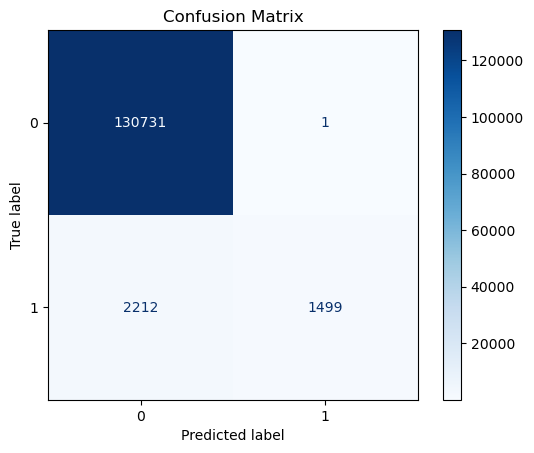

In [13]:
# Draw confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels_test_bin,result_predicted )
accuracy_per_class = cm.diagonal() / cm.sum(axis=1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

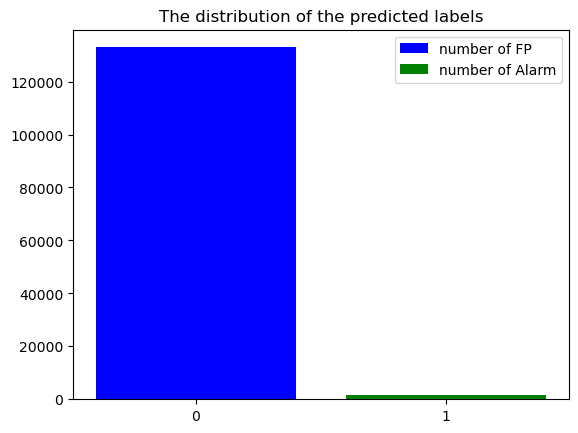

In [14]:
# The distribution of predicted labels
import matplotlib.pyplot as plt 

labels = ['0','1']
values = [num_pred_false_positive, num_pred_alarm]
#plt.figure(figsize=(8,6))
plt.figure()
bars = plt.bar(labels, values,color=['blue','green'])
plt.legend(bars,['number of FP', 'number of Alarm'])
plt.title("The distribution of the predicted labels")
plt.show()

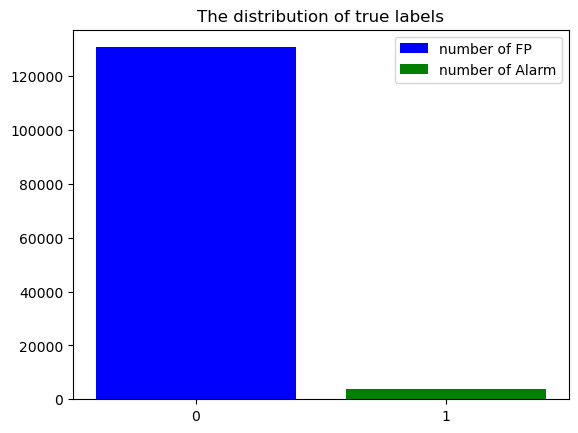

In [15]:
# The distribution of true labels
import matplotlib.pyplot as plt 

labels = ['0','1']
values = [num_label_false_positive, num_label_alarm]
#plt.figure(figsize=(8,6))
plt.figure()
bars = plt.bar(labels, values,color=['blue','green'])
plt.legend(bars,['number of FP', 'number of Alarm'])
plt.title("The distribution of true labels")
plt.show()

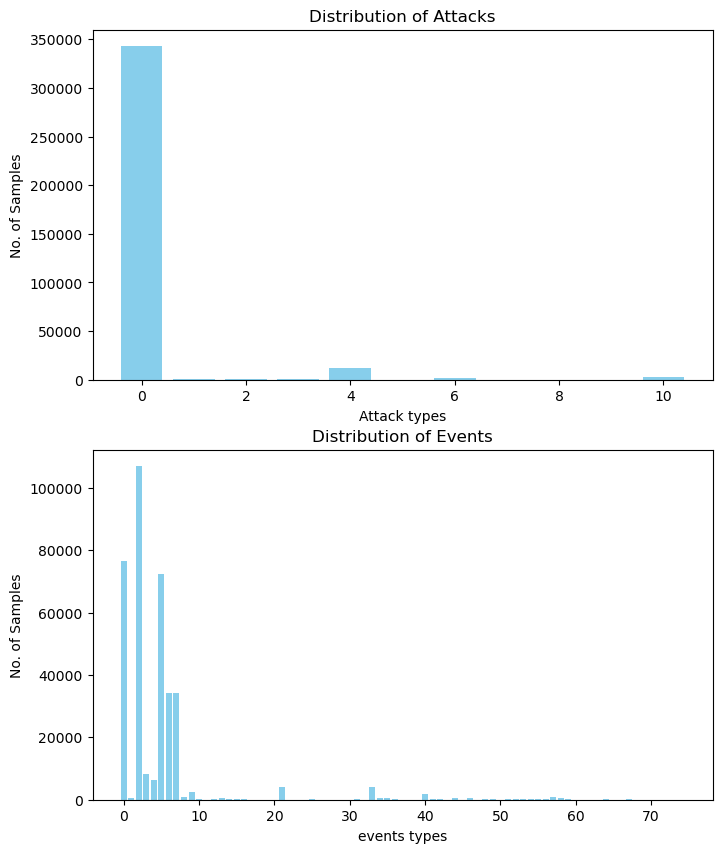

In [16]:
# Analysis the dataset. The distribution of attack types and events
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

data = Preprocessor.read_csv_files(fox_alerts,harrison_alerts,russellmitchell_alerts,santos_alerts,shaw_alerts,wardbeck_alerts,wheeler_alerts,wilson_alerts)
#data = pd.read_csv(fox_alerts)

data_labels = data['time_label']
counter_labels = Counter(data_labels)
labels_attack = list(counter_labels.keys())
values_attack = list(counter_labels.values())

mapping_attack = {i:a for i, a in enumerate(labels_attack)}
labels_attack_id = mapping_attack.keys()

events =data['short']
counter_events = Counter(events)
labels_events = list(counter_events.keys())
values_events = list(counter_events.values())

mapping_events= {i:l for i,l in enumerate(labels_events)}
labels_events_id = mapping_events.keys()
info_text = '\n'.join([f"{key}:{value}" for key, value in mapping_events.items()])

fig,(ax1,ax2) = plt.subplots(2,1, figsize=(8,10))

ax1.bar(labels_attack_id,values_attack,color='skyblue')
ax1.set_xlabel('Attack types')
ax1.set_ylabel('No. of Samples')
ax1.set_title('Distribution of Attacks')
# ax1.text(0.95, 0.95, info_text, 
#          horizontalalignment='right', 
#          verticalalignment='top', 
#          transform=plt.gca().transAxes,
#          bbox=dict(facecolor='white', alpha=0.5))

ax2.bar(labels_events_id,values_events,color='skyblue')
ax2.set_xlabel('events types')
ax2.set_ylabel('No. of Samples')
ax2.set_title('Distribution of Events')

#plt.tight_layout()
plt.show()



# plt.figure(figsize=(10,6))
# plt.bar(labels_attack,values_attack,color='skyblue')
# plt.xlabel("Attack type")
# plt.ylabel("Number of Samples")
# plt.title("Number of Samples per Attack Type")
# plt.show()


In [17]:
# Choose the hyper parameters of DBSCAN algorithm

# Get optimized vectors
vectors, mask = interpreter.attended_context(
    X                = context_test,
    y                = events_test.reshape(-1, 1),
    threshold        = 0.2,
    iterations       = 100,
    batch_size       = 1024,
    verbose          = True,
)



Optimizing query: 100%|██████████| 12700/12700 [02:26<00:00, 86.81it/s]


Text(0.5, 0, 'Points sorted by distance')

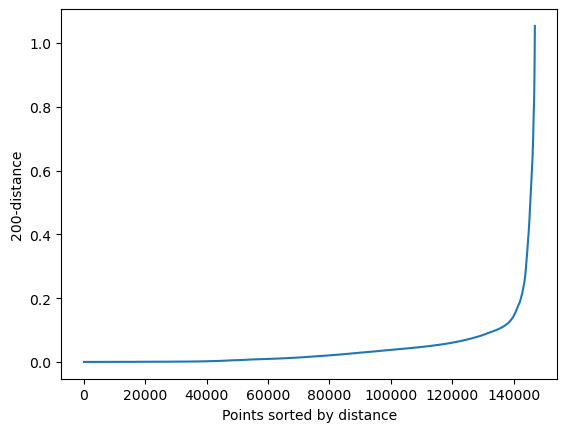

In [18]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

k=200
nn = NearestNeighbors(n_neighbors=k)
nn.fit(vectors)
distances,_ = nn.kneighbors(vectors)
distances   = np.sort(distances[:,k-1],axis=0)
plt.plot(distances)
plt.ylabel(f'{k}-distance')
plt.xlabel('Points sorted by distance')

In [19]:
import pandas as pd

fox_alerts = '../../../datasets/ait_alerts_csv/alerts_csv/fox_alerts.txt'
data = pd.read_csv(fox_alerts,sep=',')
data = data.drop_duplicates(subset=['time','ip','short'])
data.shape



(19144, 7)

In [20]:
ip = '172.17.131.81'
data_1 = data[data['ip'] == ip]

In [21]:
data_u = data.drop_duplicates(subset=['time','ip'])

In [22]:
data_u[0:30]

,time,name,ip,host,short,time_label,event_label
0,1642213952,Wazuh: ClamAV database update,172.17.131.81,mail,W-Sys-Cav,false_positive,-
1,1642213952,Wazuh: ClamAV database update,192.168.128.170,jonesmorgan_mail,W-Sys-Cav,false_positive,-
2,1642213957,Wazuh: ClamAV database update,172.17.131.81,mail,W-Sys-Cav,false_positive,-
3,1642213962,Wazuh: ClamAV database update,172.17.131.81,mail,W-Sys-Cav,false_positive,-
4,1642213967,Wazuh: ClamAV database update,172.17.131.81,mail,W-Sys-Cav,false_positive,-
5,1642213972,Wazuh: ClamAV database update,172.17.131.81,mail,W-Sys-Cav,false_positive,-
7,1642214268,Wazuh: ClamAV database update,192.168.128.195,taylorcruz_mail,W-Sys-Cav,false_positive,-
8,1642214516,Wazuh: ClamAV database update,192.168.131.228,whittaker_mail,W-Sys-Cav,false_positive,-
9,1642214769,Wazuh: ClamAV database update,192.168.129.212,miller_mail,W-Sys-Cav,false_positive,-
10,1642217552,Wazuh: ClamAV database update,192.168.128.170,jonesmorgan_mail,W-Sys-Cav,false_positive,-


In [23]:
data_u[30:60]

,time,name,ip,host,short,time_label,event_label
56,1642221207,Wazuh: ClamAV database update,172.17.131.81,mail,W-Sys-Cav,false_positive,-
57,1642221212,Wazuh: ClamAV database update,172.17.131.81,mail,W-Sys-Cav,false_positive,-
59,1642221468,Wazuh: ClamAV database update,192.168.128.195,taylorcruz_mail,W-Sys-Cav,false_positive,-
60,1642221716,Wazuh: ClamAV database update,192.168.131.228,whittaker_mail,W-Sys-Cav,false_positive,-
61,1642221969,Wazuh: ClamAV database update,192.168.129.212,miller_mail,W-Sys-Cav,false_positive,-
62,1642224386,Suricata: Alert - ET POLICY GNU/Linux APT User...,10.35.32.1,inet-firewall,S-Flw-Apt,false_positive,-
72,1642224387,Suricata: Alert - ET POLICY GNU/Linux APT User...,10.35.32.1,inet-firewall,S-Flw-Apt,false_positive,-
74,1642224542,Wazuh: IDS event.,10.35.32.1,inet-firewall,W-All-Evt,false_positive,-
78,1642224752,Wazuh: ClamAV database update,192.168.128.170,jonesmorgan_mail,W-Sys-Cav,false_positive,-
79,1642224812,Wazuh: ClamAV database update,172.17.131.81,mail,W-Sys-Cav,false_positive,-
